In [1]:
#!pip install polars
#!pip install optuna
#!pip install numpy polars pandas scikit-learn optuna scipy matplotlib missingno colorama tqdm IPython lightgbm catboost xgboost


In [1]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import missingno as msno
import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

In [39]:
%%time

train = pd.read_csv('C:/Users/Andrew/OneDrive - University of Iowa\STAT5400/Computing_project/train.csv')
test = pd.read_csv('C:/Users/Andrew/OneDrive - University of Iowa\STAT5400/Computing_project/test.csv')

#train = pd.read_csv('C:/Users/kelly/OneDrive - University of Iowa/STAT5400/Computing_project/train.csv')
#test = pd.read_csv('C:/Users/kelly/OneDrive - University of Iowa/STAT5400/Computing_project/test.csv')
#sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
       'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday','sii']

train = train[featuresCols]

CPU times: total: 15.6 ms
Wall time: 21 ms


In [41]:
%%time

# season variables (str) -> replace missing values with "NA" & convert to categorical variables 

cate_c = ['Basic_Demos-Enroll_Season','CGAS-Season','Physical-Season','Fitness_Endurance-Season','FGC-Season',
 'BIA-Season','PAQ_A-Season','PAQ_C-Season','SDS-Season','PreInt_EduHx-Season']

def update(df):
    global cate_c
    for c in cate_c : 
        df[c] = df[c].fillna('NA')
        df[c] = df[c].astype('category')
        
    return df
        
train = update(train)
test = update(test)

# for season columns -> label encoding 
# change categorical values into integer labels 
# when I do CatBoost, Label Encoding or ONE-Hot encoding is not nessecary 


from sklearn.preprocessing import LabelEncoder

for col in cate_c:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]])
    le.fit(combined)  # Fit the encoder on combined data
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

CPU times: total: 0 ns
Wall time: 16 ms


In [5]:
# data cleaning 
# use XGBoost model to fill in missing values 

import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

def fill_missing_with_xgboost(train, test, target_column, n_estimators=1000, random_state=42):
    """
    Use XGBoost model to fill in missing values in a specific feature of train and test:
    1. First merge train and test,
    2. Train the model to fill in missing values,
    3. Then split the filled train and test.
    
    Parameters:
    train (pd.DataFrame): Training dataset
    test (pd.DataFrame): Test dataset
    target_column (str): Target feature (column name) to fill missing values
    model_type (str): 'regression' or 'classification' to specify the model type
    n_estimators (int): Number of XGBoost base learners
    random_state (int): Random seed
    
    Returns:
    train_filled, test_filled: Two DataFrames (train and test with missing values filled)
    """
    
    global cat_c
    if target_column in cat_c:
        model_type = 'classification'
    else:
        model_type = 'regression'
    
    # 1. Add a marker column to identify train and test
    train['is_train'] = 1
    test['is_train'] = 0

    # Merge train and test datasets
    df = pd.concat([train, test], ignore_index=True)

    # 2. Find feature columns excluding the target column
    features_columns = df.columns[df.columns != target_column].tolist()

    # Extract rows with and without missing values
    df_missing = df[df[target_column].isnull()]  # Rows with missing values
    df_not_missing = df[~df[target_column].isnull()]  # Rows without missing values

    if df_missing.empty or df_not_missing.empty:
        print(f"No missing data in '{target_column}' column or all data are missing.")
        return train, test

    # 3. Prepare training set and features
    X_train = df_not_missing[features_columns]  # Features of rows without missing values
    y_train = df_not_missing[target_column]     # Target column of rows without missing values

    # 4. Initialize XGBoost model
    if model_type == 'regression':
        model = XGBRegressor(n_estimators=n_estimators, random_state=random_state)
    elif model_type == 'classification':
        model = XGBClassifier(n_estimators=n_estimators, random_state=random_state)
    else:
        raise ValueError("model_type should be either 'regression' or 'classification'.")

    # 5. Train the model
    model.fit(X_train, y_train)

    # 6. Predict missing values using the model
    X_pred = df_missing[features_columns]
    y_pred = model.predict(X_pred)

    # 7. Fill missing values with predictions
    df.loc[df[target_column].isnull(), target_column] = y_pred

    # 8. Split the dataset back into original train and test
    train_filled = df[df['is_train'] == 1].drop(columns=['is_train'])
    test_filled = df[df['is_train'] == 0].drop(columns=['is_train'])

    return train_filled, test_filled

tianbu_cols = ['CGAS-CGAS_Score','Physical-BMI','Physical-Height','Physical-Weight', 
               'Physical-Diastolic_BP','Physical-HeartRate','Physical-Systolic_BP', 
               'SDS-SDS_Total_Raw','SDS-SDS_Total_T','PreInt_EduHx-computerinternet_hoursday']

for col in tianbu_cols:
    print("Starting to fill feature: " + col)
    train, test = fill_missing_with_xgboost(train, test, col)




Starting to fill feature: CGAS-CGAS_Score
Starting to fill feature: Physical-BMI
Starting to fill feature: Physical-Height
Starting to fill feature: Physical-Weight
Starting to fill feature: Physical-Diastolic_BP
Starting to fill feature: Physical-HeartRate
Starting to fill feature: Physical-Systolic_BP
Starting to fill feature: SDS-SDS_Total_Raw
Starting to fill feature: SDS-SDS_Total_T
Starting to fill feature: PreInt_EduHx-computerinternet_hoursday


In [6]:
FGC_cols = [
  'FGC-FGC_CU',
  'FGC-FGC_CU_Zone',
  'FGC-FGC_GSND',
  'FGC-FGC_GSND_Zone',
  'FGC-FGC_GSD',
  'FGC-FGC_GSD_Zone',
  'FGC-FGC_PU',
  'FGC-FGC_PU_Zone',
  'FGC-FGC_SRL',
  'FGC-FGC_SRL_Zone',
  'FGC-FGC_SRR',
  'FGC-FGC_SRR_Zone',
  'FGC-FGC_TL',
  'FGC-FGC_TL_Zone'
]
for col in FGC_cols:
    print("Starting to fill feature: " + col)
    train, test = fill_missing_with_xgboost(train, test, col)

BIA = ["BIA-BIA_TBW","BIA-BIA_TBW","BIA-BIA_DEE","BIA-BIA_BMC","BIA-BIA_Fat", "BIA-BIA_BMI"]
for col in BIA:
    print("Starting to fill feature: " + col)
    train, test = fill_missing_with_xgboost(train, test, col)

Starting to fill feature: FGC-FGC_CU
Starting to fill feature: FGC-FGC_CU_Zone
Starting to fill feature: FGC-FGC_GSND
Starting to fill feature: FGC-FGC_GSND_Zone
Starting to fill feature: FGC-FGC_GSD
Starting to fill feature: FGC-FGC_GSD_Zone
Starting to fill feature: FGC-FGC_PU
Starting to fill feature: FGC-FGC_PU_Zone
Starting to fill feature: FGC-FGC_SRL
Starting to fill feature: FGC-FGC_SRL_Zone
Starting to fill feature: FGC-FGC_SRR
Starting to fill feature: FGC-FGC_SRR_Zone
Starting to fill feature: FGC-FGC_TL
Starting to fill feature: FGC-FGC_TL_Zone
Starting to fill feature: BIA-BIA_TBW
Starting to fill feature: BIA-BIA_TBW
No missing data in 'BIA-BIA_TBW' column or all data are missing.
Starting to fill feature: BIA-BIA_DEE
Starting to fill feature: BIA-BIA_BMC
Starting to fill feature: BIA-BIA_Fat
Starting to fill feature: BIA-BIA_BMI


In [7]:
train = update(train)
test = update(test)

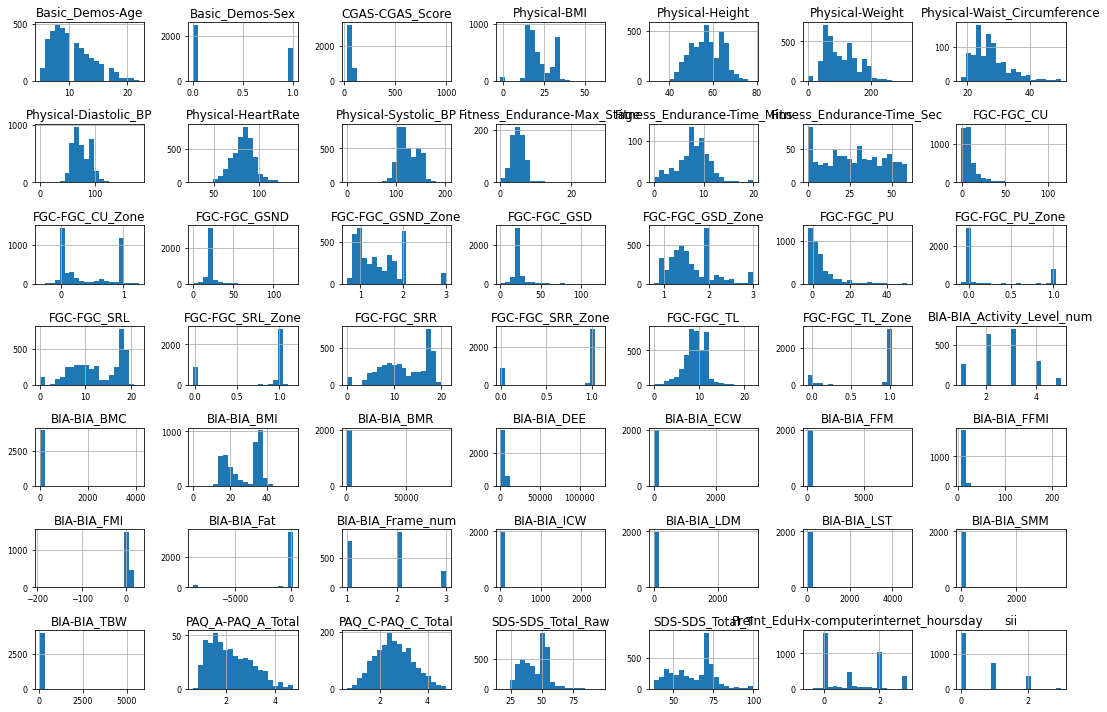

Wall time: 11.5 s


In [8]:
%%time

train.hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

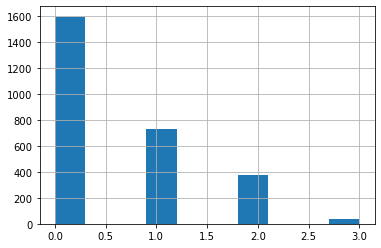

In [9]:
if 'sii' in train.columns:
    train = train.dropna(subset=['sii'])
    train["sii"].hist()
else:
    print("Column 'sii' does not exist in the DataFrame.")

In [10]:
missing_percent_train = train.isnull().mean() * 100
missing_percent_train

Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                                0.000000
CGAS-CGAS_Score                            0.000000
Physical-Season                            0.000000
Physical-BMI                               0.000000
Physical-Height                            0.000000
Physical-Weight                            0.000000
Physical-Waist_Circumference              82.346491
Physical-Diastolic_BP                      0.000000
Physical-HeartRate                         0.000000
Physical-Systolic_BP                       0.000000
Fitness_Endurance-Season                   0.000000
Fitness_Endurance-Max_Stage               73.282164
Fitness_Endurance-Time_Mins               73.391813
Fitness_Endurance-Time_Sec                73.391813
FGC-Season                                 0.000000
FGC-FGC_CU                                 0.000000
FGC-FGC_CU_Z

In [11]:
missing_percent_test = test.isnull().mean() * 100
missing_percent_test

Basic_Demos-Enroll_Season                   0.0
Basic_Demos-Age                             0.0
Basic_Demos-Sex                             0.0
CGAS-Season                                 0.0
CGAS-CGAS_Score                             0.0
Physical-Season                             0.0
Physical-BMI                                0.0
Physical-Height                             0.0
Physical-Weight                             0.0
Physical-Waist_Circumference               75.0
Physical-Diastolic_BP                       0.0
Physical-HeartRate                          0.0
Physical-Systolic_BP                        0.0
Fitness_Endurance-Season                    0.0
Fitness_Endurance-Max_Stage                85.0
Fitness_Endurance-Time_Mins                85.0
Fitness_Endurance-Time_Sec                 85.0
FGC-Season                                  0.0
FGC-FGC_CU                                  0.0
FGC-FGC_CU_Zone                             0.0
FGC-FGC_GSND                            

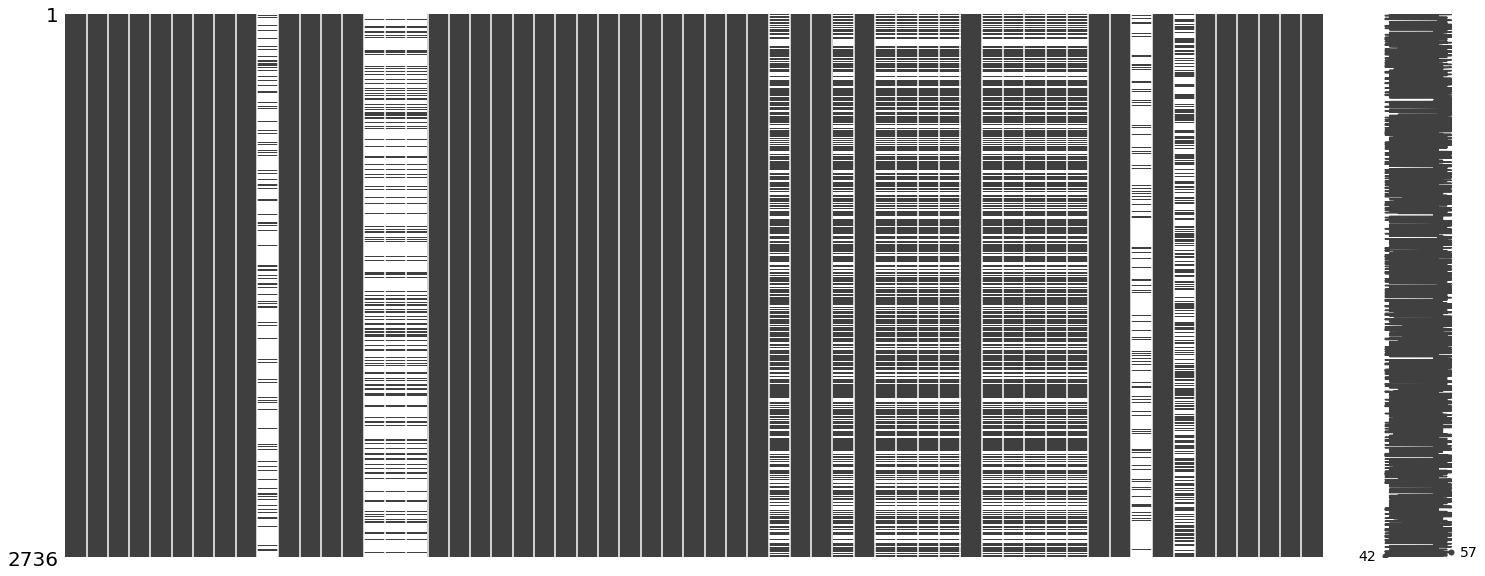

In [12]:
msno.matrix(train)
plt.show()

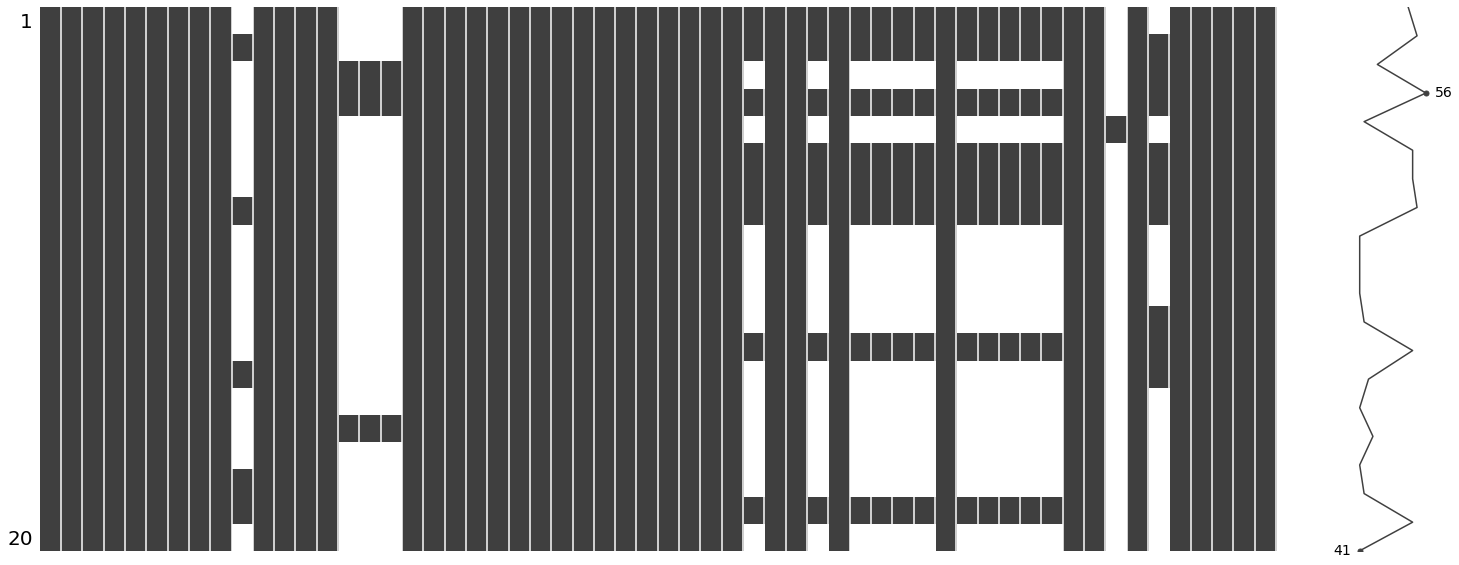

In [13]:
msno.matrix(test)
plt.show()

In [14]:
# interaction feature
def create_interaction_features(df, feature_pairs):
    global cat_c
    for feature1, feature2 in feature_pairs:
        if feature1 not in cat_c or feature2 not in cat_c:
            print("feature1: " + feature1 + ", feature2: " + feature2)
            new_feature_name = f"{feature1}_x_{feature2}"
            df[new_feature_name] = df[feature1] * df[feature2]
    return df

def create_division_features(df, feature_pairs):
    global cat_c
    for feature1, feature2 in feature_pairs:
        if feature1 not in cat_c or feature2 not in cat_c:
            print(f"feature1: {feature1}, feature2: {feature2}")
            
            # Create A/B feature, handle division by zero or NaN
            new_feature_name1 = f"{feature1}_div_{feature2}"
            df[new_feature_name1] = df[feature1] / df[feature2]
            
            # Mask NaN or zero values
            df[new_feature_name1] = df[new_feature_name1].mask((df[feature1] == 0) | (df[feature2] == 0) | 
                                                               df[feature1].isna() | df[feature2].isna())
            
            # Create B/A feature, handle similarly
            new_feature_name2 = f"{feature2}_div_{feature1}"
            df[new_feature_name2] = df[feature2] / df[feature1]
            df[new_feature_name2] = df[new_feature_name2].mask((df[feature1] == 0) | (df[feature2] == 0) | 
                                                               df[feature1].isna() | df[feature2].isna())

    return df

feature_pairs = [
    ('PreInt_EduHx-computerinternet_hoursday', 'Basic_Demos-Age'),
    ('Basic_Demos-Age', 'SDS-SDS_Total_T'),
    ('FGC-FGC_SRR_Zone', 'SDS-SDS_Total_T'),
    ('BIA-BIA_BMC', 'Physical-HeartRate'),
    #('Fitness_Endurance-Season', 'Physical-Waist_Circumference'),
    ('BIA-BIA_Fat', 'Physical-BMI'),
    ('PreInt_EduHx-Season', 'Fitness_Endurance-Season'),
    ('SDS-SDS_Total_T', 'Physical-Systolic_BP'),
    ('Basic_Demos-Sex', 'FGC-FGC_PU_Zone')
]

train = create_interaction_features(train, feature_pairs)
test = create_interaction_features(test, feature_pairs)
train = create_division_features(train, feature_pairs)
test = create_division_features(test, feature_pairs)

feature1: PreInt_EduHx-computerinternet_hoursday, feature2: Basic_Demos-Age
feature1: Basic_Demos-Age, feature2: SDS-SDS_Total_T
feature1: FGC-FGC_SRR_Zone, feature2: SDS-SDS_Total_T
feature1: BIA-BIA_BMC, feature2: Physical-HeartRate
feature1: BIA-BIA_Fat, feature2: Physical-BMI
feature1: SDS-SDS_Total_T, feature2: Physical-Systolic_BP
feature1: Basic_Demos-Sex, feature2: FGC-FGC_PU_Zone
feature1: PreInt_EduHx-computerinternet_hoursday, feature2: Basic_Demos-Age
feature1: Basic_Demos-Age, feature2: SDS-SDS_Total_T
feature1: FGC-FGC_SRR_Zone, feature2: SDS-SDS_Total_T
feature1: BIA-BIA_BMC, feature2: Physical-HeartRate
feature1: BIA-BIA_Fat, feature2: Physical-BMI
feature1: SDS-SDS_Total_T, feature2: Physical-Systolic_BP
feature1: Basic_Demos-Sex, feature2: FGC-FGC_PU_Zone
feature1: PreInt_EduHx-computerinternet_hoursday, feature2: Basic_Demos-Age
feature1: Basic_Demos-Age, feature2: SDS-SDS_Total_T
feature1: FGC-FGC_SRR_Zone, feature2: SDS-SDS_Total_T
feature1: BIA-BIA_BMC, feature2: 

In [15]:
train
# Save the train DataFrame to a CSV file
train.to_csv('C:/Users/kelly/OneDrive - University of Iowa\STAT5400\Computing_project/train_xgboost.csv', index=False)

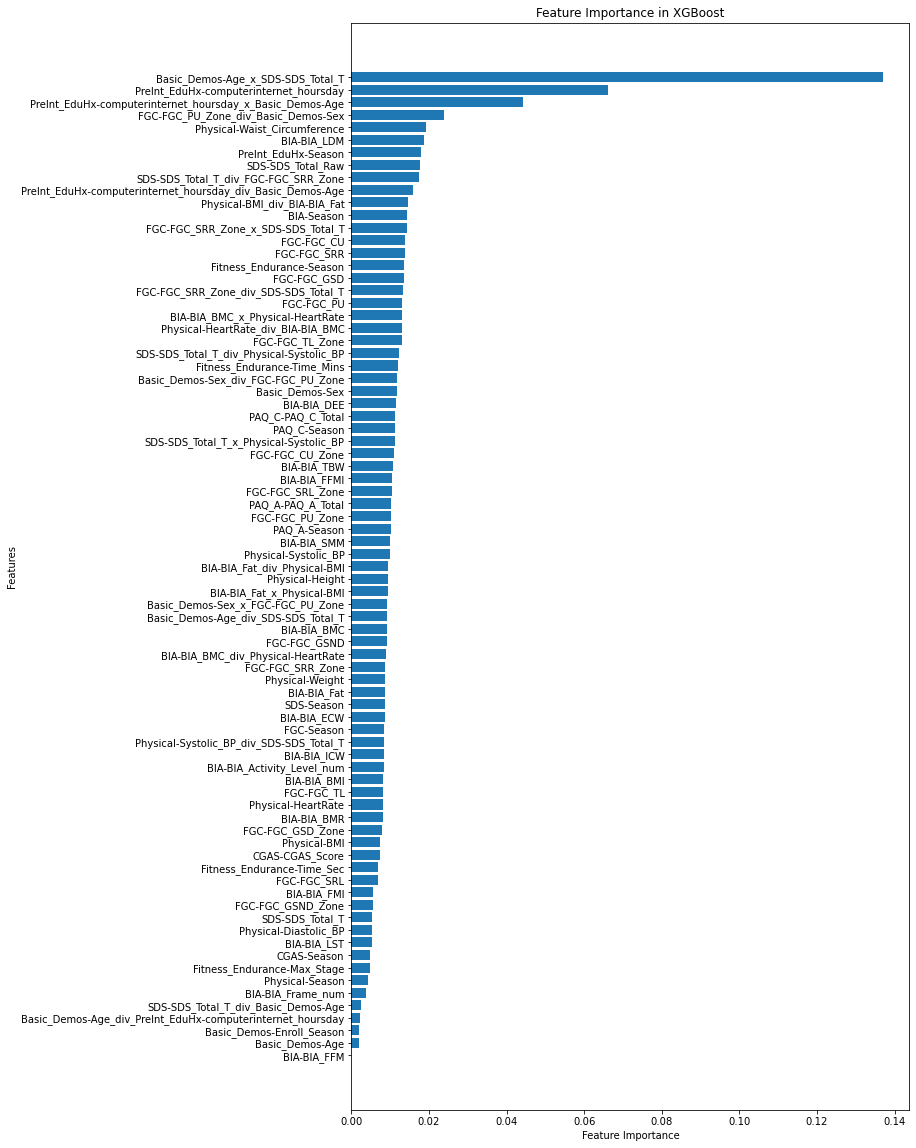

In [16]:
# Feature Importance 
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Prepare the data
X = train.drop(['sii'], axis=1)
y = train['sii']

# Train the XGBoost model
XGBoost = xgb.XGBRegressor(random_state=SEED, enable_categorical=True)
XGBoost.fit(X, y)

# Get feature importance
importance = XGBoost.feature_importances_

# Get feature names
features = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

In [17]:
##### this code is added to check the code performance 
# code performance check 
# performance metrics 

from sklearn.model_selection import train_test_split

# Assuming 'train' is your original DataFrame
X = train.drop(['sii'], axis=1)
y = train['sii']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Train the XGBoost model on the training set
XGBoost = xgb.XGBRegressor(random_state=SEED, enable_categorical=True)
XGBoost.fit(X_train, y_train)

# Predict on the validation set
y_pred = XGBoost.predict(X_val)

# Calculate MSE
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse}")



Mean Squared Error: 0.5322234515913726


In [18]:
##### this code is added to check the code performance 

from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(XGBRegressor(random_state=SEED, enable_categorical=True), X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()}")

Cross-Validation MSE: 0.5145464010712468


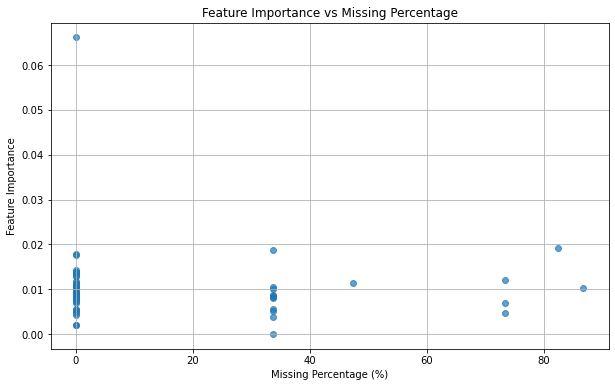

In [19]:
# 特徴量の名前を取得
features = X.columns

# データフレームとして整理（特徴量重要度と欠損値の割合を結合）
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
missing_df = pd.DataFrame({'Feature': missing_percent_train.index, 'MissingPercent': missing_percent_train.values})
combined_df = pd.merge(importance_df, missing_df, on='Feature')

# 散布図を作成
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['MissingPercent'], combined_df['Importance'], alpha=0.7)
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Feature Importance')
plt.title('Feature Importance vs Missing Percentage')
plt.grid(True)
plt.show()

In [20]:
# Get the set of columns for each DataFrame
train_columns = set(train.columns)
test_columns = set(test.columns)

# Find columns only in train but not in test
train_only = train_columns - test_columns

# Find columns only in test but not in train
test_only = test_columns - train_columns

# Output the different columns
print(f"Columns only in train: {train_only}")
print(f"Columns only in test: {test_only}")

Columns only in train: set()
Columns only in test: set()


In [22]:
%%time

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds, 0,
                    np.where(oof_non_rounded < thresholds, 1,
                             np.where(oof_non_rounded < thresholds, 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']
    test_data = test_data.drop(['sii'], axis=1)
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, tKappa


Wall time: 0 ns


In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lightgbm as lgb

# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 12, 18],
    'num_leaves': [31, 127, 255],
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [1, 4, 7],
    'lambda_l1': [0, 1, 10],
    'lambda_l2': [0, 0.01, 0.1]
}

# Initialize the LightGBM model
lgbm_model = lgb.LGBMRegressor(random_state=SEED)

# Initialize GridSearchCV or RandomizedSearchCV
grid_search_lgbm = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid_lgbm, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=SEED)

# Fit the search
grid_search_lgbm.fit(X_train, y_train)

# Get the best parameters
best_params_lgbm = grid_search_lgbm.best_params_
print(f"Best parameters for LightGBM: {best_params_lgbm}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning

In [24]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import scipy.stats as st

# Define the parameter distribution for XGBoost
param_dist_xgb = {
    'learning_rate': st.uniform(0.01, 0.2),
    'max_depth': st.randint(3, 10),
    'n_estimators': st.randint(100, 1000),
    'subsample': st.uniform(0.6, 1.0),
    'colsample_bytree': st.uniform(0.6, 1.0),
    'reg_alpha': st.uniform(0, 10),
    'reg_lambda': st.uniform(0, 10)
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=SEED, enable_categorical=True)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=SEED)

# Fit the search
random_search_xgb.fit(X_train, y_train)

# Get the best parameters
best_params_xgb = random_search_xgb.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for XGBoost: {'colsample_bytree': 0.9169220051562776, 'learning_rate': 0.0438985493372185, 'max_depth': 3, 'n_estimators': 834, 'reg_alpha': 8.442131407263114, 'reg_lambda': 9.300168348108318, 'subsample': 0.6704161308495439}


In [26]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
import scipy.stats as st

# Define the parameter distribution for CatBoost
param_dist_catboost = {
    'iterations': st.randint(100, 1000),
    'learning_rate': st.uniform(0.01, 0.1),
    'l2_leaf_reg': st.uniform(1, 10),
    'subsample': st.uniform(0.5, 1.0),
    'random_strength': st.uniform(1, 2),
    'bagging_temperature': st.uniform(0, 1),
    'border_count': st.randint(5, 20)
}

# Initialize the CatBoost model
catboost_model = CatBoostRegressor(random_state=SEED, silent=True)

# Initialize RandomizedSearchCV
random_search_catboost = RandomizedSearchCV(estimator=catboost_model, param_distributions=param_dist_catboost, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=SEED)

# Fit the search
random_search_catboost.fit(X_train, y_train)

# Get the best parameters
best_params_catboost = random_search_catboost.best_params_
print(f"Best parameters for CatBoost: {best_params_catboost}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


CatBoostError: features data: pandas.DataFrame column 'Basic_Demos-Enroll_Season' has dtype 'category' but is not in  cat_features list

In [29]:
#num_leaves': 127, 'min_data_in_leaf': 30, 'max_depth': 6, 'learning_rate': 0.05, 
#'lambda_l2': 0, 'lambda_l1': 10, 'feature_fraction': 0.8, 'bagging_freq': 4, 
#'bagging_fraction': 0.9

best_params_lgbm = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 127,
    'min_data_in_leaf': 30,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0
}

#Fitting 5 folds for each of 100 candidates, totalling 500 fits
# Best parameters for XGBoost: {'colsample_bytree': 0.9169220051562776, 
#'learning_rate': 0.0438985493372185, 'max_depth': 3, 'n_estimators': 834, 
#'reg_alpha': 8.442131407263114, 'reg_lambda': 9.300168348108318, 
#'subsample': 0.6704161308495439}

best_params_xgb = {
    'learning_rate': 0.0438985493372185,
    'max_depth': 3,
    'n_estimators': 834,
    'subsample': .6704161308495439,
    'colsample_bytree': 0.9169220051562776,
    'reg_alpha': 8.442131407263114,
    'reg_lambda': 9.300168348108318
}
#best_params_catboost = {
#    'iterations': 804,
#    'learning_rate': 0.007849710402582562, 
#    'l2_leaf_reg': 7.31183636902306, 
#    'subsample': 0.5630297785016092, 
#    'random_strength': 1.7097065892440113, 
#    'bagging_temperature': 0.026593521316435192,
#    'border_count': 12
#}

In [30]:
%%time
# LightGBM
Light = lgb.LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
Submission_LGBM, k_lgbm = TrainML(Light, test)

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

Mean Train QWK --> 0.5950
Mean Validation QWK ---> 0.3862


ValueError: operands could not be broadcast together with shapes (2736,) (3,) 

In [35]:
%%time
XGBoost = xgb.XGBRegressor(**best_params_xgb, random_state=SEED,enable_categorical=True)
Submission_XGB, k_xgb = TrainML(XGBoost, test)

Training Folds:   0%|          | 0/5 [00:02<?, ?it/s]


ValueError: feature_names mismatch: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'PreInt_EduHx-computerinternet_hoursday_x_Basic_Demos-Age', 'Basic_Demos-Age_x_SDS-SDS_Total_T', 'FGC-FGC_SRR_Zone_x_SDS-SDS_Total_T', 'BIA-BIA_BMC_x_Physical-HeartRate', 'BIA-BIA_Fat_x_Physical-BMI', 'SDS-SDS_Total_T_x_Physical-Systolic_BP', 'Basic_Demos-Sex_x_FGC-FGC_PU_Zone', 'PreInt_EduHx-computerinternet_hoursday_div_Basic_Demos-Age', 'Basic_Demos-Age_div_PreInt_EduHx-computerinternet_hoursday', 'Basic_Demos-Age_div_SDS-SDS_Total_T', 'SDS-SDS_Total_T_div_Basic_Demos-Age', 'FGC-FGC_SRR_Zone_div_SDS-SDS_Total_T', 'SDS-SDS_Total_T_div_FGC-FGC_SRR_Zone', 'BIA-BIA_BMC_div_Physical-HeartRate', 'Physical-HeartRate_div_BIA-BIA_BMC', 'BIA-BIA_Fat_div_Physical-BMI', 'Physical-BMI_div_BIA-BIA_Fat', 'SDS-SDS_Total_T_div_Physical-Systolic_BP', 'Physical-Systolic_BP_div_SDS-SDS_Total_T', 'Basic_Demos-Sex_div_FGC-FGC_PU_Zone', 'FGC-FGC_PU_Zone_div_Basic_Demos-Sex', 'Basic_Demos-Enroll_Season_0', 'Basic_Demos-Enroll_Season_1', 'Basic_Demos-Enroll_Season_2', 'Basic_Demos-Enroll_Season_3', 'CGAS-Season_0', 'CGAS-Season_1', 'CGAS-Season_2', 'CGAS-Season_3', 'CGAS-Season_4', 'Physical-Season_0', 'Physical-Season_1', 'Physical-Season_2', 'Physical-Season_3', 'Physical-Season_4', 'Fitness_Endurance-Season_0', 'Fitness_Endurance-Season_1', 'Fitness_Endurance-Season_2', 'Fitness_Endurance-Season_3', 'Fitness_Endurance-Season_4', 'FGC-Season_0', 'FGC-Season_1', 'FGC-Season_2', 'FGC-Season_3', 'FGC-Season_4', 'BIA-Season_0', 'BIA-Season_1', 'BIA-Season_2', 'BIA-Season_3', 'BIA-Season_4', 'PAQ_A-Season_0', 'PAQ_A-Season_1', 'PAQ_A-Season_2', 'PAQ_A-Season_3', 'PAQ_A-Season_4', 'PAQ_C-Season_0', 'PAQ_C-Season_1', 'PAQ_C-Season_2', 'PAQ_C-Season_3', 'PAQ_C-Season_4', 'SDS-Season_0', 'SDS-Season_1', 'SDS-Season_2', 'SDS-Season_3', 'SDS-Season_4', 'PreInt_EduHx-Season_0', 'PreInt_EduHx-Season_1', 'PreInt_EduHx-Season_2', 'PreInt_EduHx-Season_3', 'PreInt_EduHx-Season_4'] ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'PreInt_EduHx-computerinternet_hoursday_x_Basic_Demos-Age', 'Basic_Demos-Age_x_SDS-SDS_Total_T', 'FGC-FGC_SRR_Zone_x_SDS-SDS_Total_T', 'BIA-BIA_BMC_x_Physical-HeartRate', 'BIA-BIA_Fat_x_Physical-BMI', 'SDS-SDS_Total_T_x_Physical-Systolic_BP', 'Basic_Demos-Sex_x_FGC-FGC_PU_Zone', 'PreInt_EduHx-computerinternet_hoursday_div_Basic_Demos-Age', 'Basic_Demos-Age_div_PreInt_EduHx-computerinternet_hoursday', 'Basic_Demos-Age_div_SDS-SDS_Total_T', 'SDS-SDS_Total_T_div_Basic_Demos-Age', 'FGC-FGC_SRR_Zone_div_SDS-SDS_Total_T', 'SDS-SDS_Total_T_div_FGC-FGC_SRR_Zone', 'BIA-BIA_BMC_div_Physical-HeartRate', 'Physical-HeartRate_div_BIA-BIA_BMC', 'BIA-BIA_Fat_div_Physical-BMI', 'Physical-BMI_div_BIA-BIA_Fat', 'SDS-SDS_Total_T_div_Physical-Systolic_BP', 'Physical-Systolic_BP_div_SDS-SDS_Total_T', 'Basic_Demos-Sex_div_FGC-FGC_PU_Zone', 'FGC-FGC_PU_Zone_div_Basic_Demos-Sex', 'Basic_Demos-Enroll_Season_0', 'Basic_Demos-Enroll_Season_1', 'Basic_Demos-Enroll_Season_2', 'Basic_Demos-Enroll_Season_3', 'CGAS-Season_0', 'CGAS-Season_1', 'CGAS-Season_2', 'CGAS-Season_3', 'CGAS-Season_4', 'Physical-Season_0', 'Physical-Season_1', 'Physical-Season_2', 'Physical-Season_3', 'Physical-Season_4', 'Fitness_Endurance-Season_0', 'Fitness_Endurance-Season_1', 'Fitness_Endurance-Season_2', 'Fitness_Endurance-Season_3', 'FGC-Season_0', 'FGC-Season_1', 'FGC-Season_2', 'FGC-Season_3', 'FGC-Season_4', 'BIA-Season_0', 'BIA-Season_1', 'BIA-Season_2', 'BIA-Season_3', 'PAQ_A-Season_0', 'PAQ_A-Season_1', 'PAQ_C-Season_0', 'PAQ_C-Season_1', 'PAQ_C-Season_2', 'PAQ_C-Season_3', 'PAQ_C-Season_4', 'SDS-Season_0', 'SDS-Season_1', 'SDS-Season_2', 'SDS-Season_3', 'SDS-Season_4', 'PreInt_EduHx-Season_0', 'PreInt_EduHx-Season_1', 'PreInt_EduHx-Season_2', 'PreInt_EduHx-Season_3', 'PreInt_EduHx-Season_4']
expected Fitness_Endurance-Season_4, PAQ_A-Season_3, BIA-Season_4, PAQ_A-Season_4, PAQ_A-Season_2 in input data

In [45]:
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)


In [46]:
def threshold_Rounder(oof_non_rounded, thresholds):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    thresholds = np.array(thresholds)
    return np.where(oof_non_rounded[:, None] < thresholds, 0,
                    np.where(oof_non_rounded[:, None] < thresholds, 1,
                             np.where(oof_non_rounded[:, None] < thresholds, 2, 3))).flatten()


In [51]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from tqdm import tqdm
import lightgbm as lgb

# Define the quadratic_weighted_kappa function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Define the threshold_Rounder function with length check and array conversion
def threshold_Rounder(oof_non_rounded, thresholds):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    thresholds = np.array(thresholds)
    return np.where(oof_non_rounded[:, None] < thresholds, 0,
                    np.where(oof_non_rounded[:, None] < thresholds, 1,
                             np.where(oof_non_rounded[:, None] < thresholds, 2, 3))).flatten()

# Define the evaluate_predictions function with length check
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Define the TrainML function
def TrainML(model_class, train, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']
    test_data = test_data.drop(['sii'], axis=1)
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, tKappa

# Ensure train and test have the same columns
common_columns = list(set(train.columns) & set(test.columns))
train = train[common_columns]
test = test[common_columns]

# Ensure the order of columns is the same
train = train.sort_index(axis=1)
test = test.sort_index(axis=1)

# Define best parameters for LightGBM and XGBoost models
best_params_lgbm = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 127,
    'min_data_in_leaf': 30,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0
}

best_params_xgb = {
    'learning_rate': 0.0438985493372185,
    'max_depth': 3,
    'n_estimators': 834,
    'subsample': .6704161308495439,
    'colsample_bytree': 0.9169220051562776,
    'reg_alpha': 8.442131407263114,
    'reg_lambda': 9.300168348108318
}

# Set random seed and number of splits for StratifiedKFold
SEED = 42
n_splits = 5

# Train the LightGBM model
Light = lgb.LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
Submission_LGBM, k_lgbm = TrainML(Light, train, test)




Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.50it/s]

Fold 1 - Train QWK: 0.5691, Validation QWK: 0.3643


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.20it/s]

Fold 2 - Train QWK: 0.5896, Validation QWK: 0.4259


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.38it/s]

Fold 3 - Train QWK: 0.5898, Validation QWK: 0.4003


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.42it/s]

Fold 4 - Train QWK: 0.6145, Validation QWK: 0.3924


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

Fold 5 - Train QWK: 0.6086, Validation QWK: 0.3849
Mean Train QWK --> 0.5943
Mean Validation QWK ---> 0.3936


ValueError: Found input variables with inconsistent numbers of samples: [2736, 8208]

In [52]:

# Train the XGBoost model
XGBoost = xgb.XGBRegressor(**best_params_xgb, random_state=SEED, enable_categorical=True)
Submission_XGB, k_xgb = TrainML(XGBoost, train, test)

Training Folds:  20%|██        | 1/5 [00:04<00:17,  4.30s/it]

Fold 1 - Train QWK: 0.6974, Validation QWK: 0.3733


Training Folds:  40%|████      | 2/5 [00:09<00:14,  4.95s/it]

Fold 2 - Train QWK: 0.6942, Validation QWK: 0.4175


Training Folds:  60%|██████    | 3/5 [00:13<00:08,  4.39s/it]

Fold 3 - Train QWK: 0.7018, Validation QWK: 0.4362


Training Folds:  80%|████████  | 4/5 [00:17<00:04,  4.15s/it]

Fold 4 - Train QWK: 0.6911, Validation QWK: 0.3447


Training Folds: 100%|██████████| 5/5 [00:23<00:00,  4.61s/it]

Fold 5 - Train QWK: 0.7080, Validation QWK: 0.3812
Mean Train QWK --> 0.6985
Mean Validation QWK ---> 0.3906


ValueError: Found input variables with inconsistent numbers of samples: [2736, 8208]

In [54]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from tqdm import tqdm
import lightgbm as lgb

# Define the quadratic_weighted_kappa function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Define the threshold_Rounder function with length check and array conversion
def threshold_Rounder(oof_non_rounded, thresholds):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    thresholds = np.array(thresholds)
    return np.where(oof_non_rounded[:, None] < thresholds, 0,
                    np.where(oof_non_rounded[:, None] < thresholds, 1,
                             np.where(oof_non_rounded[:, None] < thresholds, 2, 3))).flatten()

# Define the evaluate_predictions function with length check
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Define the TrainML function
def TrainML(model_class, train, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']
    test_data = test_data.drop(['sii'], axis=1)
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, tKappa

# Ensure train and test have the same columns
common_columns = list(set(train.columns) & set(test.columns))
train = train[common_columns]
test = test[common_columns]

# Ensure the order of columns is the same
train = train.sort_index(axis=1)
test = test.sort_index(axis=1)

# Define best parameters for LightGBM and XGBoost models
best_params_lgbm = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 127,
    'min_data_in_leaf': 30,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0
}

best_params_xgb = {
    'learning_rate': 0.0438985493372185,
    'max_depth': 3,
    'n_estimators': 834,
    'subsample': .6704161308495439,
    'colsample_bytree': 0.9169220051562776,
    'reg_alpha': 8.442131407263114,
    'reg_lambda': 9.300168348108318
}

# Set random seed and number of splits for StratifiedKFold
SEED = 42
n_splits = 5

# Train the LightGBM model
Light = lgb.LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
Submission_LGBM, k_lgbm = TrainML(Light, train, test)




Training Folds:  20%|██        | 1/5 [00:00<00:01,  3.68it/s]

Fold 1 - Train QWK: 0.5691, Validation QWK: 0.3643


Training Folds:  40%|████      | 2/5 [00:00<00:00,  4.08it/s]

Fold 2 - Train QWK: 0.5896, Validation QWK: 0.4259


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  4.03it/s]

Fold 3 - Train QWK: 0.5898, Validation QWK: 0.4003


Training Folds:  80%|████████  | 4/5 [00:00<00:00,  4.22it/s]

Fold 4 - Train QWK: 0.6145, Validation QWK: 0.3924


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

Fold 5 - Train QWK: 0.6086, Validation QWK: 0.3849
Mean Train QWK --> 0.5943
Mean Validation QWK ---> 0.3936


ValueError: Found input variables with inconsistent numbers of samples: [2736, 8208]

In [55]:
# Train the XGBoost model
XGBoost = xgb.XGBRegressor(**best_params_xgb, random_state=SEED, enable_categorical=True)
Submission_XGB, k_xgb = TrainML(XGBoost, train, test)

Training Folds:  20%|██        | 1/5 [00:02<00:11,  2.78s/it]

Fold 1 - Train QWK: 0.6974, Validation QWK: 0.3733


Training Folds:  40%|████      | 2/5 [00:05<00:07,  2.62s/it]

Fold 2 - Train QWK: 0.6942, Validation QWK: 0.4175


Training Folds:  60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

Fold 3 - Train QWK: 0.7018, Validation QWK: 0.4362


Training Folds:  80%|████████  | 4/5 [00:11<00:03,  3.13s/it]

Fold 4 - Train QWK: 0.6911, Validation QWK: 0.3447


Training Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

Fold 5 - Train QWK: 0.7080, Validation QWK: 0.3812
Mean Train QWK --> 0.6985
Mean Validation QWK ---> 0.3906


ValueError: Found input variables with inconsistent numbers of samples: [2736, 8208]

In [56]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from tqdm import tqdm
import lightgbm as lgb

# Define the quadratic_weighted_kappa function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Define the threshold_Rounder function with length check and array conversion
def threshold_Rounder(oof_non_rounded, thresholds):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    thresholds = np.array(thresholds)
    return np.where(oof_non_rounded[:, None] < thresholds, 0,
                    np.where(oof_non_rounded[:, None] < thresholds, 1,
                             np.where(oof_non_rounded[:, None] < thresholds, 2, 3))).flatten()

# Define the evaluate_predictions function with length check
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    if len(thresholds) != 3:
        raise ValueError("Thresholds array must have exactly 3 elements.")
    if len(y_true) != len(oof_non_rounded):
        raise ValueError("y_true and oof_non_rounded must have the same length.")
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Define the TrainML function
def TrainML(model_class, train, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']
    test_data = test_data.drop(['sii'], axis=1)
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, tKappa

# Ensure train and test have the same columns
common_columns = list(set(train.columns) & set(test.columns))
train = train[common_columns]
test = test[common_columns]

# Ensure the order of columns is the same
train = train.sort_index(axis=1)
test = test.sort_index(axis=1)

# Define best parameters for LightGBM and XGBoost models
best_params_lgbm = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 127,
    'min_data_in_leaf': 30,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0
}

best_params_xgb = {
    'learning_rate': 0.0438985493372185,
    'max_depth': 3,
    'n_estimators': 834,
    'subsample': .6704161308495439,
    'colsample_bytree': 0.9169220051562776,
    'reg_alpha': 8.442131407263114,
    'reg_lambda': 9.300168348108318
}

# Set random seed and number of splits for StratifiedKFold
SEED = 42
n_splits = 5

# Train the LightGBM model
Light = lgb.LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
Submission_LGBM, k_lgbm = TrainML(Light, train, test)

# Train the XGBoost model
XGBoost = xgb.XGBRegressor(**best_params_xgb, random_state=SEED, enable_categorical=True)
Submission_XGB, k_xgb = TrainML(XGBoost, train, test)


Training Folds:  20%|██        | 1/5 [00:00<00:00,  4.23it/s]

Fold 1 - Train QWK: 0.5691, Validation QWK: 0.3643


Training Folds:  40%|████      | 2/5 [00:00<00:00,  3.90it/s]

Fold 2 - Train QWK: 0.5896, Validation QWK: 0.4259


Training Folds:  60%|██████    | 3/5 [00:00<00:00,  3.49it/s]

Fold 3 - Train QWK: 0.5898, Validation QWK: 0.4003


Training Folds:  80%|████████  | 4/5 [00:01<00:00,  3.63it/s]

Fold 4 - Train QWK: 0.6145, Validation QWK: 0.3924


Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

Fold 5 - Train QWK: 0.6086, Validation QWK: 0.3849
Mean Train QWK --> 0.5943
Mean Validation QWK ---> 0.3936


ValueError: Found input variables with inconsistent numbers of samples: [2736, 8208]